# Generative Models

## GANs & VAE

### HW4

**Full Name: Ehsan Hassanbeygi**

**SID: 402211723**

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [2]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [3]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14392897.13it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 463572.60it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4360356.32it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2202627.91it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
num_threads = 4
batch_size = 256

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [ ]:
from torch.nn.functional import relu


class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
    ):
        super(ConvBlock, self).__init__()
        self.e1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.e2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        xe1 = relu(self.e1(x))
        xe2 = relu(self.e2(xe1))
        xp = self.pool(xe2)

        return xe2, xp


class TransConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
    ):
        super(TransConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2
        )
        self.d1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.d2 = nn.Conv2d(
            in_channels // 2, in_channels // 2, kernel_size=3, padding=1
        )

    def forward(self, x):
        xu11 = self.upconv(x)
        xd11 = relu(self.d1(xu11))
        xd12 = relu(self.d2(xd11))

        return xd12

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        ##########################################################
        self.conv_block1 = ConvBlock(1, 16)
        self.conv_block2 = ConvBlock(16, 32)
        self.conv_block3 = ConvBlock(32, 64)

        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.trans_conv_block1 = TransConvBlock(512)
        self.trans_conv_block2 = TransConvBlock(256)
        self.trans_conv_block3 = TransConvBlock(128)
        self.trans_conv_block4 = TransConvBlock(64)

        self.outconv = nn.Conv2d(32, 3, kernel_size=1)


    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        ##########################################################

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        ##############################

        # TODO

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        ########################################

        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        ##########################################################

        return image, z_mean, z_log_var

In [ ]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [ ]:
def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = # TODO
    criterion = # TODO
    optimizer = # TODO

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                ###############################################

            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        recon_image = reconstruct_images(model, sample_images)

    return model

In [ ]:
model = train_vae()

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [32]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        self.img_shape = img_shape
        self.n_channel_base = 64
        self.output_channels = 1

        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(
                latent_dim,
                self.n_channel_base * 4,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(self.n_channel_base * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 4 x 4``
            nn.ConvTranspose2d(
                self.n_channel_base * 4,
                self.n_channel_base * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(self.n_channel_base * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 8 x 8``
            nn.ConvTranspose2d(
                self.n_channel_base * 2,
                self.n_channel_base,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(self.n_channel_base),
            nn.ReLU(True),
            # state size. ``(ngf) x 16 x 16``
            nn.ConvTranspose2d(
                self.n_channel_base,
                self.output_channels,
                kernel_size=4,
                stride=2,
                padding=3,
                bias=False,
            ),
            nn.Tanh(),
            # state size. ``(nc) x 28 x 28``
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################
        img = self.model(z)
#         print(f"generator output shape: {img.shape}")

        return img


class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        self.n_channel_base = 64
        self.img_channels = 1

        self.model = nn.Sequential(
            # input is ``(nc) x 28 x 28``
            nn.Conv2d(
                self.img_channels,
                self.n_channel_base,
                kernel_size=4,
                stride=2,
                padding=3,
                bias=False,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 16 x 16``

            nn.Conv2d(
                self.n_channel_base,
                self.n_channel_base * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(self.n_channel_base * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 8 x 8``

            nn.Conv2d(
                self.n_channel_base * 2,
                self.n_channel_base * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(self.n_channel_base * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 4 x 4``

            nn.Conv2d(
                self.n_channel_base * 4,
                1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
            # state size. ``1``
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        x = self.model(img)
        x = x.squeeze(-1).squeeze(-1)
#         print(f"discriminator output shape: {x.shape}")

        return x

In [38]:
from torch.autograd import Variable
from torch import Tensor


def train_gan(
    dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100
):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, img_shape).to(DEVICE)
    generator.apply(weights_init)
    discriminator = Discriminator(img_shape).to(DEVICE)
    discriminator.apply(weights_init)

    adversarial_loss = torch.nn.BCELoss()
    optimizer_G = torch.optim.Adam(
        generator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
    )
    optimizer_D = torch.optim.Adam(
        discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
    )
    
    num_samples = 4
    samples = torch.randn(num_samples, latent_dim, 1, 1, device=DEVICE)

    for epoch in range(num_epochs):
        g_loss_total = 0.0
        d_loss_total = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################
                imgs = imgs.to(DEVICE)

                valid = Variable(
                    Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False
                ).to(DEVICE)
                fake = Variable(
                    Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False
                ).to(DEVICE)
                real_imgs = Variable(imgs.type(Tensor)).to(DEVICE)

                optimizer_G.zero_grad()
#                 z = Variable(
#                     Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))
#                 ).to(DEVICE)
#                 print(imgs.shape, end=" ")
                z = torch.randn(imgs.shape[0], latent_dim, 1, 1, device=DEVICE)
                gen_imgs = generator(z)

                g_loss = adversarial_loss(discriminator(gen_imgs), valid)
                g_loss_total += g_loss.item()
                g_loss.backward()
                optimizer_G.step()

                optimizer_D.zero_grad()

                real_loss = adversarial_loss(discriminator(real_imgs), valid)
                fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss_total += d_loss.item()

                d_loss.backward()
                optimizer_D.step()

                pbar.set_description(
                    "[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(
                        epoch, num_epochs, d_loss.item(), g_loss.item()
                    )
                )

            print("Generator Loss: {:.4f}".format(g_loss_total / len(dataloader)))
            print("Discriminator Loss: {:.4f}".format(d_loss_total / len(dataloader)))

        # Plot generated images after each epoch
        with torch.no_grad():
            recon_images = generator(samples)
        fig = plt.figure(figsize=(10, 60))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(f"Generated Image")
            plt.axis("off")
            plt.imshow(
                recon_images[i].detach().cpu().reshape(img_shape[1], img_shape[2]),
                cmap="gray",
            )
            plt.tight_layout()
        plt.show()
    return generator, discriminator

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.8778
Discriminator Loss: 0.0633


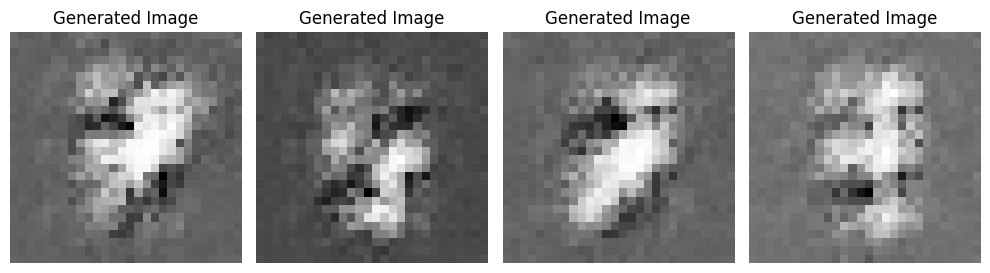

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 4.2649
Discriminator Loss: 0.0543


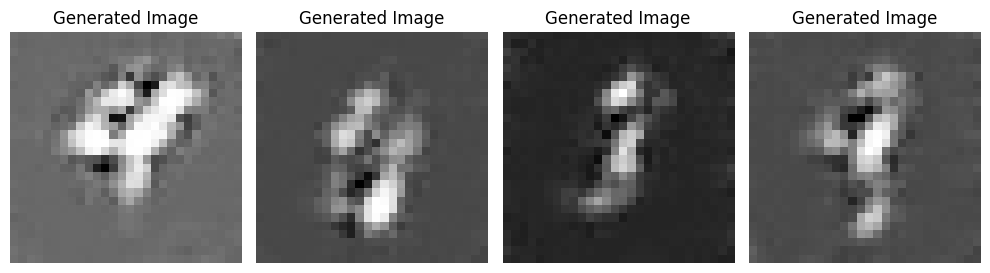

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 4.2163
Discriminator Loss: 0.0669


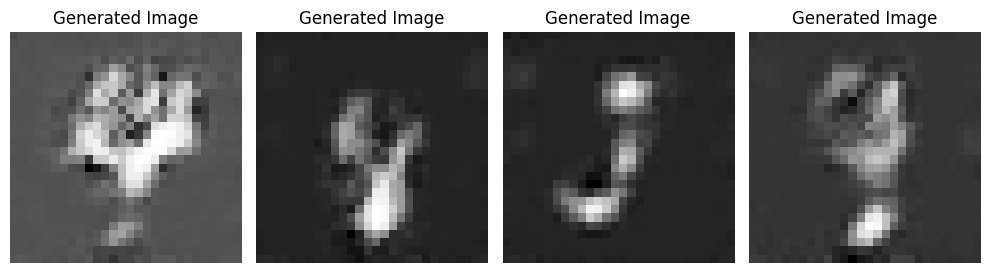

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 4.1167
Discriminator Loss: 0.0663


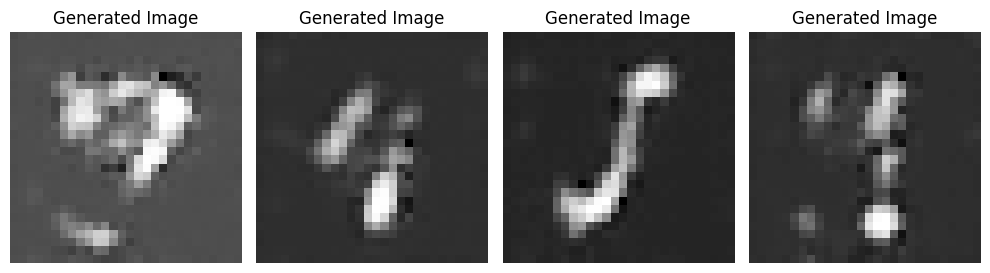

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.9443
Discriminator Loss: 0.1225


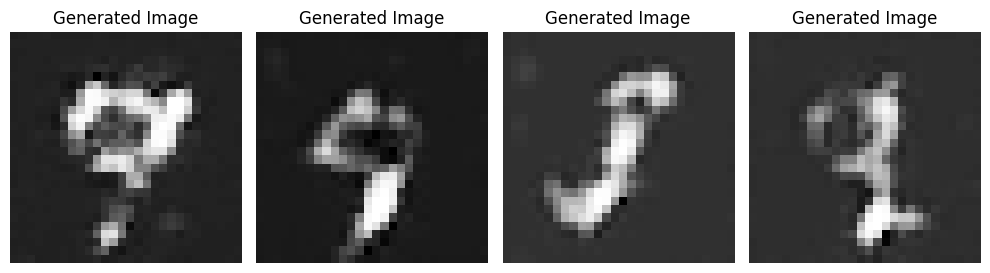

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 4.0129
Discriminator Loss: 0.0914


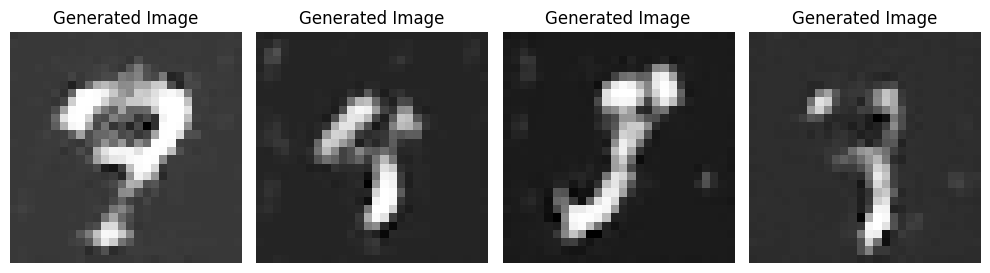

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.7872
Discriminator Loss: 0.1155


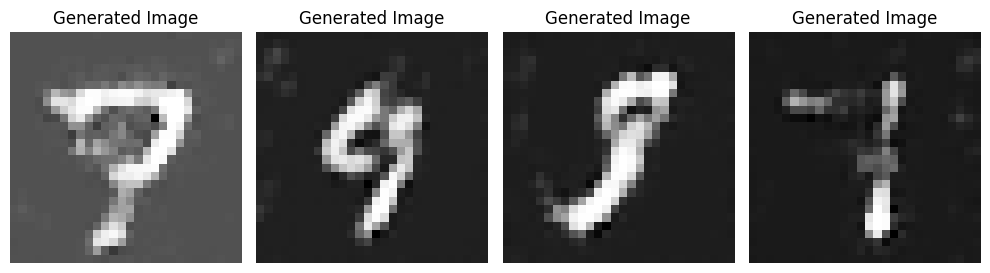

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.3953
Discriminator Loss: 0.1725


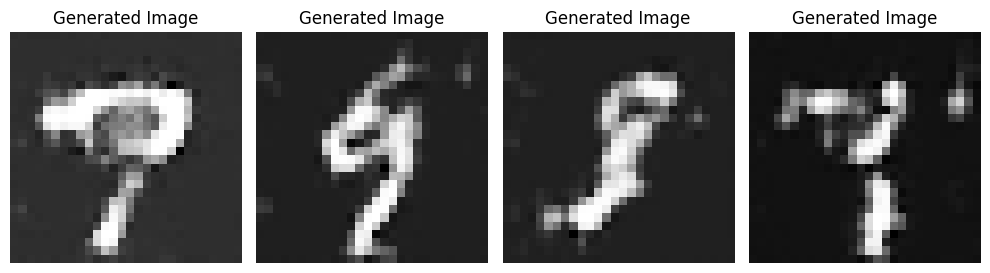

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.3460
Discriminator Loss: 0.1374


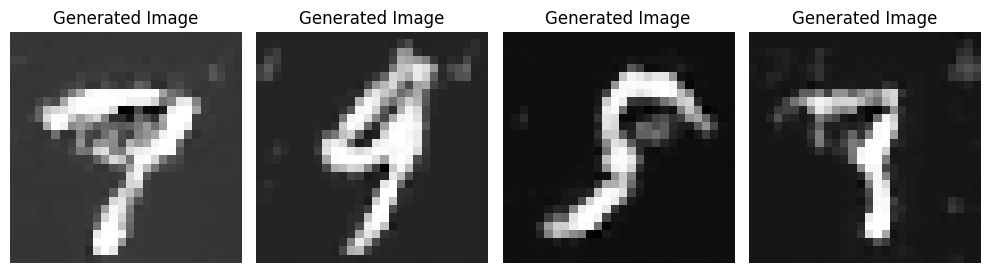

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.1996
Discriminator Loss: 0.1677


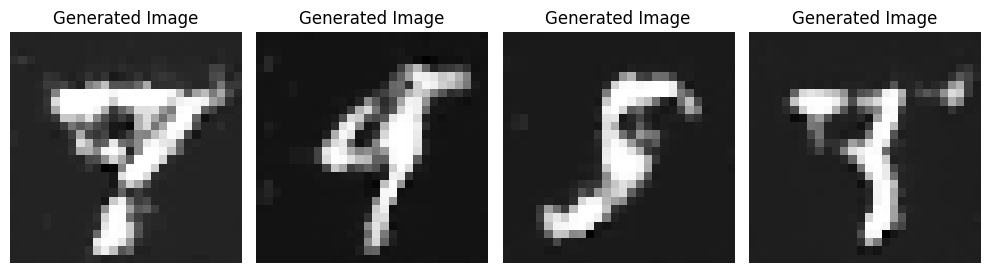

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 2.9197
Discriminator Loss: 0.1707


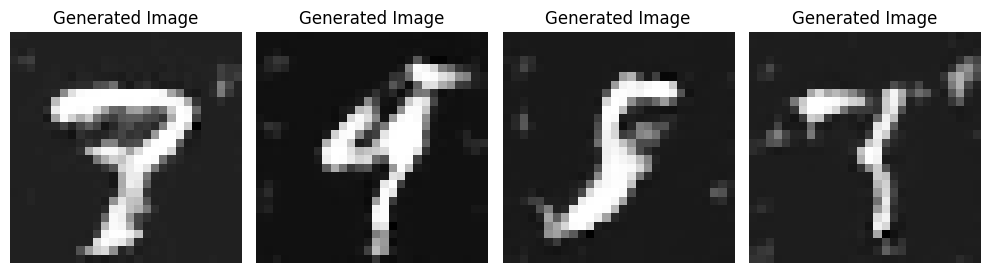

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.1961
Discriminator Loss: 0.1493


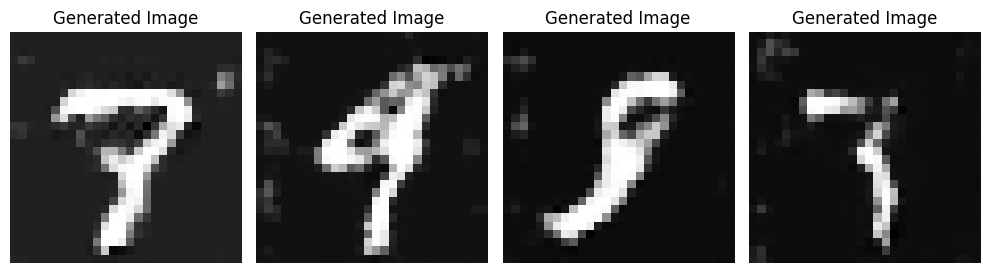

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.2402
Discriminator Loss: 0.1397


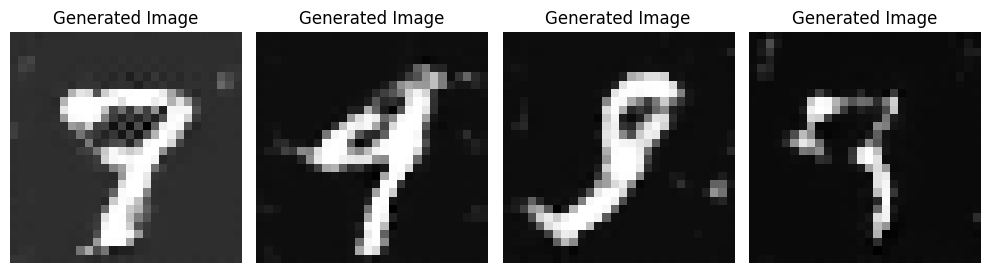

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.2423
Discriminator Loss: 0.1718


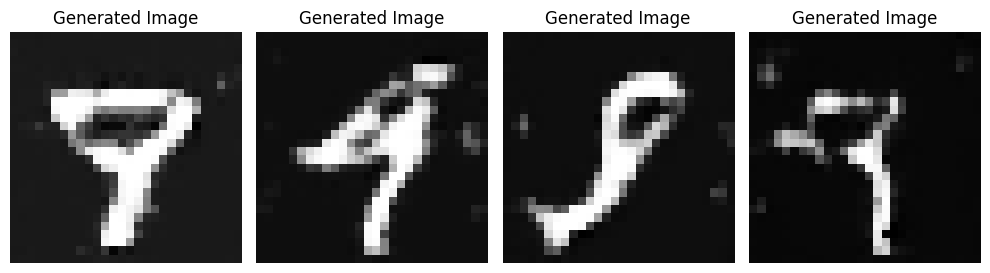

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 2.8750
Discriminator Loss: 0.1407


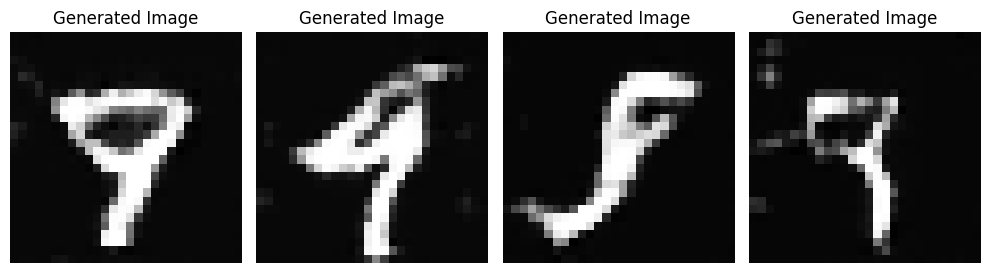

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 2.8896
Discriminator Loss: 0.1810


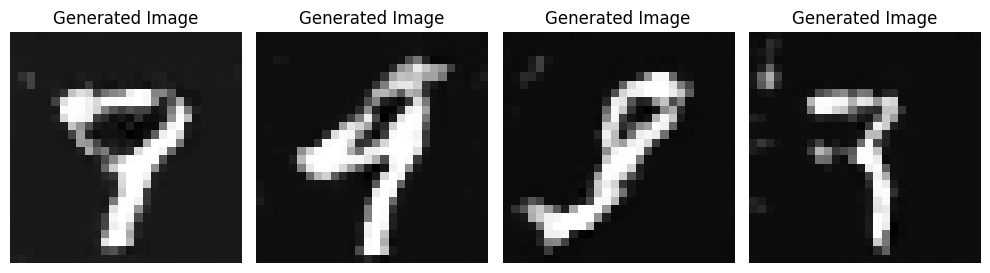

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 2.9910
Discriminator Loss: 0.1633


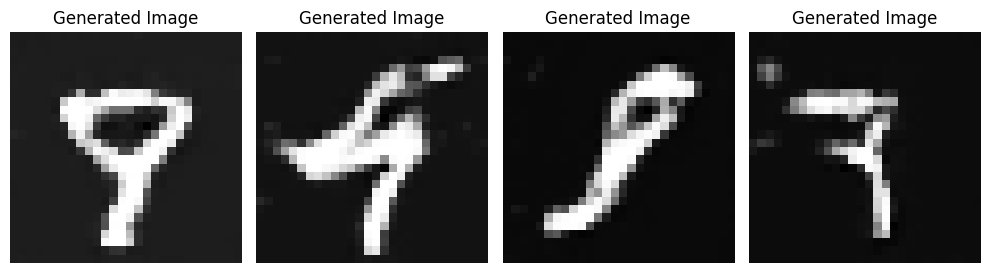

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 3.0058
Discriminator Loss: 0.1401


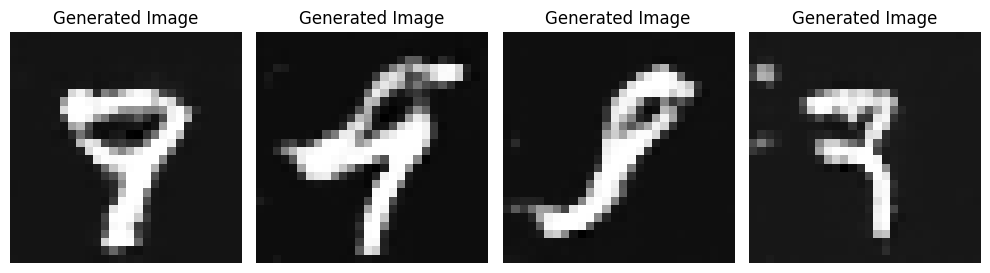

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 2.8471
Discriminator Loss: 0.1971


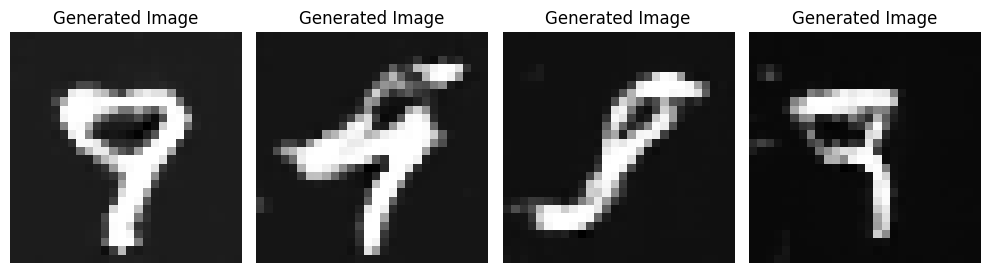

  0%|          | 0/196 [00:00<?, ?it/s]

Generator Loss: 2.9157
Discriminator Loss: 0.1481


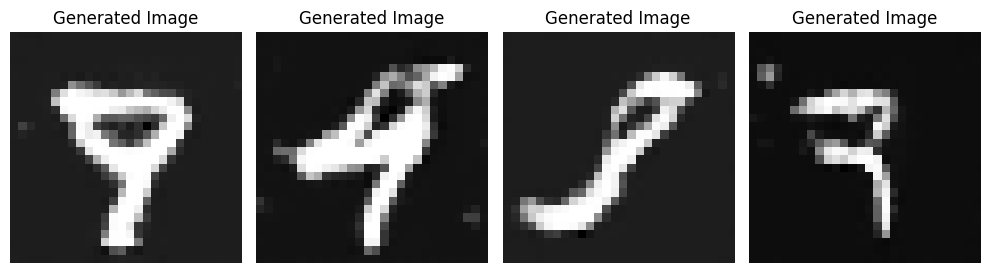

In [39]:
generator, discriminator = train_gan(
    dataloader=train_loader, latent_dim=100, learning_rate=2e-4, num_epochs=20
)

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [ ]:
# TODO
# Comparison of the generated images